# **Import thư viện**

In [1]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix



# **Load data**

In [2]:
path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'


train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

# **Trực quan hóa phân bố của các mẫu dữ liệu**

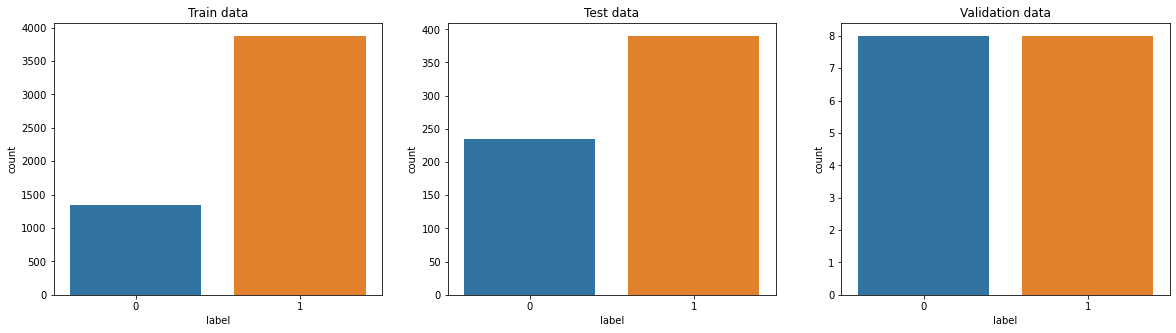

In [3]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

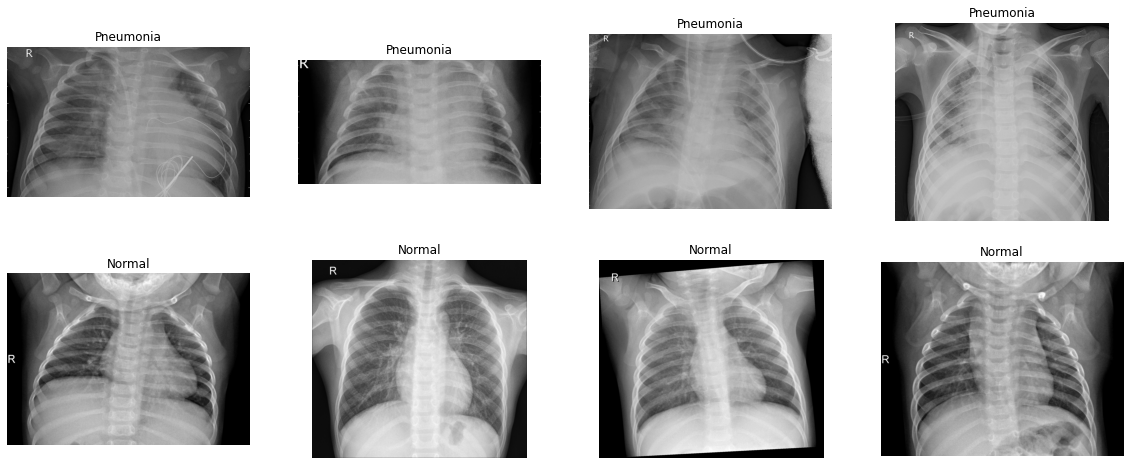

In [4]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

# **Tiền xử lý dữ liệu**

In [5]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [6]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


**Image augmentation**

In [7]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# **Xây dựng Mô hình CNN**
Một mô hình tuần tự đơn giản được triển khai, bắt đầu với 2 tầng tích chập sử dụng kernel kích thước (7,7) và tầng gộp tối đa (max pooling) với kích thước vùng gộp (3,3), tiếp theo là 2 tầng tích chập khác với kernel kích thước (7,7) và cùng kích thước vùng gộp. Cuối cùng, mô hình bao gồm nhiều khối lặp lại, mỗi khối gồm 2 tầng tích chập với kernel kích thước (3,3), kết hợp với tầng gộp tối đa có kích thước vùng gộp (2,2).

In [9]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 196, 8)       400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 8)       3144      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 65, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 65, 16)        3216      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 65, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 32)        4

In [10]:
callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})

Epoch 1/100
1304/1304 [==============================] - 16s 13ms/step - loss: 0.6924 - accuracy: 0.4887 - val_loss: 0.5290 - val_accuracy: 0.8269
Epoch 2/100
1304/1304 [==============================] - 17s 13ms/step - loss: 0.3597 - accuracy: 0.8129 - val_loss: 0.3561 - val_accuracy: 0.8670
Epoch 3/100
1304/1304 [==============================] - 16s 12ms/step - loss: 0.3018 - accuracy: 0.8560 - val_loss: 0.3462 - val_accuracy: 0.8990
Epoch 4/100
1304/1304 [==============================] - 17s 13ms/step - loss: 0.2539 - accuracy: 0.8796 - val_loss: 0.2952 - val_accuracy: 0.9022
Epoch 5/100
1304/1304 [==============================] - 16s 13ms/step - loss: 0.2358 - accuracy: 0.8915 - val_loss: 0.5121 - val_accuracy: 0.7804
Epoch 6/100
1304/1304 [==============================] - 16s 13ms/step - loss: 0.2124 - accuracy: 0.8961 - val_loss: 0.3187 - val_accuracy: 0.8894
Epoch 7/100
1304/1304 [==============================] - 16s 12ms/step - loss: 0.2159 - accuracy: 0.9049 - val_loss: 0

## **Vẽ biểu đồ hàm mất mát (loss) trên dữ liệu huấn luyện so với dữ liệu kiểm tra.**

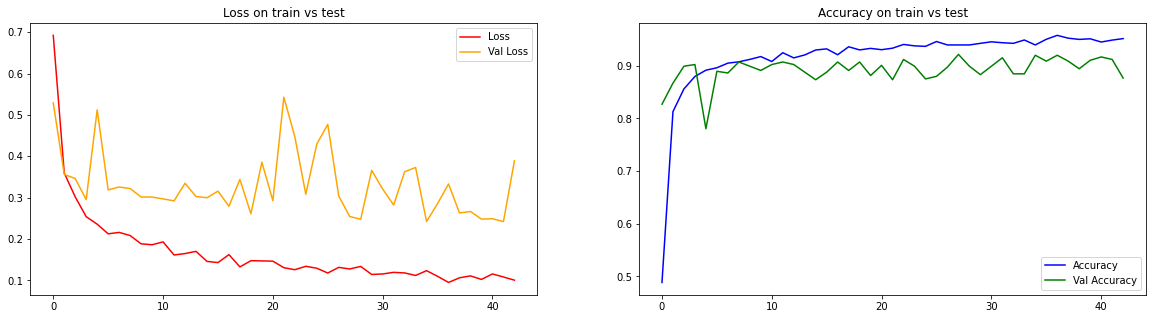

In [11]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

## **Confusion matrix**

In [12]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

In [13]:
from sklearn.metrics import accuracy_score

# Calculate accuracy on test data
test_accuracy = accuracy_score(y_test, y_test_hat)

# Print the accuracy
print(f"Accuracy on test data: {test_accuracy:.4f}")

Accuracy on test data: 0.8766


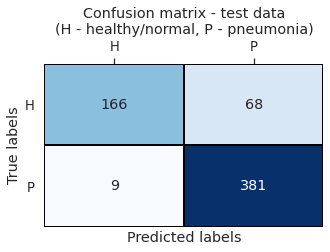

Classification report on test data
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       234
           1       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



In [14]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

## Validation data

In [15]:
y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)

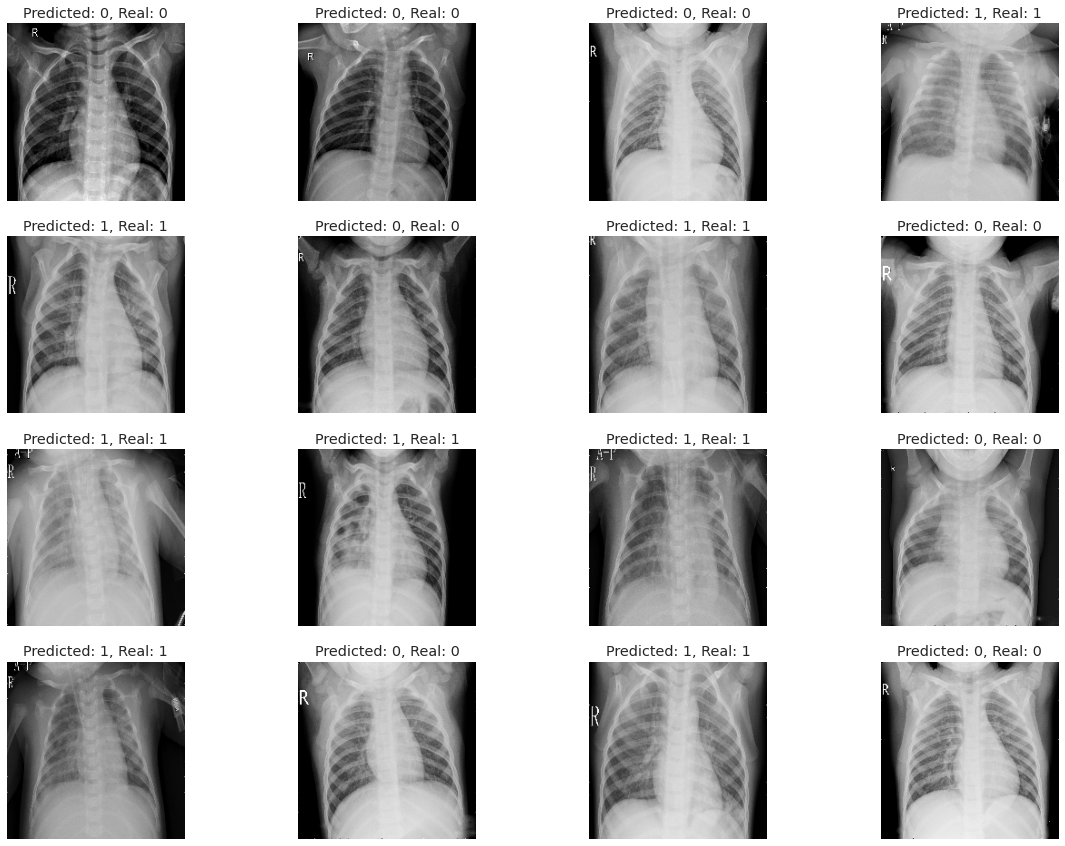

In [16]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]))  

In [17]:
def predict_image(model, img_path):
    img = process_data(img_path)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_label = np.argmax(prediction, axis=1)[0]
    
    return "Normal" if predicted_label == 0 else "Pneumonia"

In [18]:
img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
result = predict_image(model, img_path)
print(f"Predicted result: {result}")

Predicted result: Pneumonia


In [19]:
model.save("model.h5")